In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob

In [3]:
fdir = '/data2/GBT/S140/'

In [202]:
fnamesA = glob.glob(fdir+'Daisy/*/*_03_*D*rfireduced.npz')
fnamesA.sort()
print len(fnamesA)

24


In [203]:
x = np.load(fnamesA[0])

In [204]:
N = 2**14
df = x['CDELT1'][0]
center_freq = x['CRVAL1'][0]
centerbin = x['CRPIX1'][0]
index = np.arange(N)
if_freqs = index * (-df) # in Hz
freqs1 = (center_freq + df * (index + 1 - centerbin))[::-1]

In [205]:
freqs1

array([  6.42509155e+09,   6.42518311e+09,   6.42527466e+09, ...,
         7.92481689e+09,   7.92490845e+09,   7.92500000e+09])

In [206]:
print center_freq
print centerbin
print df

7175000000.0
8193.0
-91552.734375


In [207]:
N = 2**14
df = 1500. / N * 1.e6
center_freq = 7175.e6
centerbin = N / 2
index = np.arange(N)
if_freqs = index * df 
freqs = (center_freq - df * (index - centerbin))[::-1]

In [208]:
freqs

array([  6.42509155e+09,   6.42518311e+09,   6.42527466e+09, ...,
         7.92481689e+09,   7.92490845e+09,   7.92500000e+09])

In [209]:
np.any(freqs1 - freqs)

False

In [167]:
freqs

array([  3.82509155e+09,   3.82518311e+09,   3.82527466e+09, ...,
         5.32481689e+09,   5.32490845e+09,   5.32500000e+09])

In [168]:
df

-91552.734375

In [172]:
1500. / N * 1.e6

91552.734375

In [169]:
center_freq

4575000000.0

In [173]:
4575 * 1.e6

4575000000.0

In [170]:
centerbin

8193.0

In [174]:
N / 2

8192

In [165]:
x['freqs']

array([             nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,              nan,              nan,
                    nan,

In [5]:
fnames = glob.glob('/data2/GBT/*295/OnOff/*/*_03_*B*rfireduced.npz')
fnames.sort()
print len(fnames)

2


In [6]:
def S295(freqs):
    a0 = 1.4866 
    a1 = -0.7871
    a2 = -0.3440
    a3 = 0.0749
    f = freqs * 1.e-9
    logf = np.log10(f)
    logS = a0 + a1*logf + a2*logf**2 + a3*logf**3
    return 10.**(logS)

In [7]:
def get_freqs_pdiode(k=0, show=True):
    x = np.load(fnames[k])
    y = np.load(fnames[k+1])
    print fnames[k]
    print fnames[k+1]
    if np.any(x['valid'] ^ y['valid']):
        print "CHECK MASK"
    mask = x['valid']
    freqs = x['freqs']

    if x['source'] == 'ON' and y['source'] == 'OFF':
        onSonD = x['xxon']
        onSoffD = x['xxoff']
        offSonD = y['xxon']
        offSoffD = y['xxoff']
    elif x['source'] == 'OFF' and y['source'] == 'ON':
        onSonD = y['xxon']
        onSoffD = y['xxoff']
        offSonD = x['xxon']
        offSoffD = x['xxoff']
    else:
        print "DISASTER"
    
    Psource = S295(freqs)
    gain = np.nanmean(onSoffD[200:,:] - offSoffD[200:,:], 0) / Psource
    Pdiode = np.nanmean(offSonD[200:,:] - offSoffD[200:,:], 0) / gain
    if show:
        figure()
        plot(freqs, np.nanmean(onSonD[200:,mask], 0), label='onSonD')
        plot(freqs, np.nanmean(onSoffD[200:,mask], 0), label='onSoffD')
        plot(freqs, np.nanmean(offSonD[200:,mask], 0), label='offSonD')
        plot(freqs, np.nanmean(offSoffD[200:,mask], 0), label='offSoffD')
        legend()
        figure()
        plot(freqs, Pdiode)
        xlabel('frequency')
        ylabel('Jy')
    return freqs, Pdiode

In [8]:
fdiode, pdiode = get_freqs_pdiode(0, False)

/data2/GBT/3C295/OnOff/scan_03_6.raw.vegas/scan_03_6.raw.vegas.B.fits.rfireduced.npz
/data2/GBT/3C295/OnOff/scan_03_7.raw.vegas/scan_03_7.raw.vegas.B.fits.rfireduced.npz


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: Mean of empty slice
/usr/lib/python2.7/site-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice


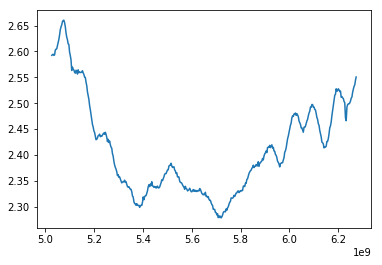

In [9]:
plot(fdiode, pdiode)

In [10]:
def naive_map(data,ra,dec,ra_num_bins=60,dec_num_bins=50):
    ra_bins = np.linspace(ra.min(),ra.max(),ra_num_bins)
    dec_bins = np.linspace(dec.min(),dec.max(),dec_num_bins)
    p,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins),weights=data)
    hits,_,_ = np.histogram2d(ra,dec,bins=(ra_bins,dec_bins))
    return p, hits, ra_bins, dec_bins

In [134]:
calibratedA = [] 
ras = []
decs = []
gains = []
eles = []
for fname in fnamesA[:-2]:
    nz = np.load(fname)
    ra = nz['sra']
    dec = nz['sdec']
    mask = nz['valid']
    ele = nz['ELEVATIO']
    calib = np.nanmean((nz['xxoff'] * pdiode / nz['xxon'])[:,mask], 1)
    calibratedA = np.concatenate([calibratedA, calib])
    ras = np.concatenate([ras, ra])
    decs = np.concatenate([decs, dec])
    eles = np.concatenate([eles, ele])

In [135]:
len(calibratedA)

152746

In [136]:
len(ras)

152746

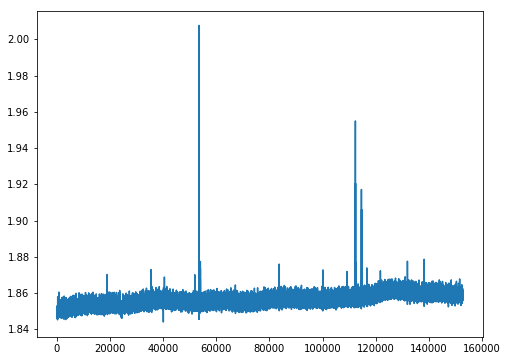

In [113]:
plot(calibratedA)

In [114]:
def moving_median(x, N):
    idx = np.arange(N) + np.arange(len(x) - N + 1)[:, None]
    return np.nanmedian(x[idx], axis=1)


In [137]:
mvmed = moving_median(calibratedA, 9)

In [138]:
flat = calibratedA[4:-4] - mvmed

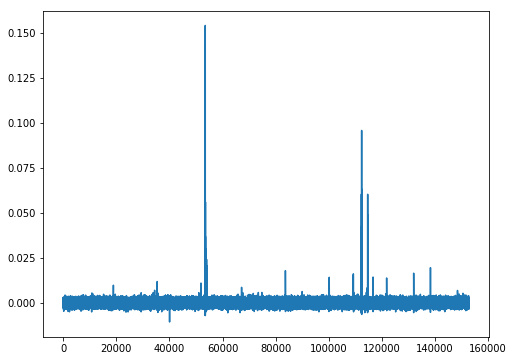

In [139]:
plot(flat)

In [140]:
mask = np.abs(flat) > 4 * np.std(flat)

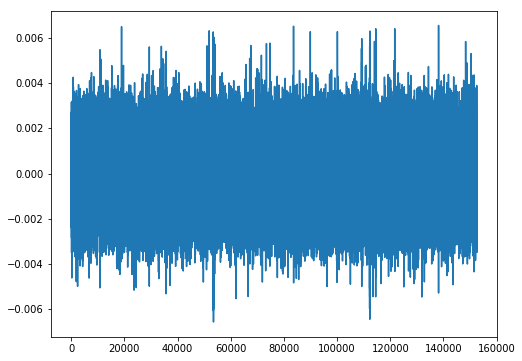

In [141]:
plot(flat[~mask])

In [142]:
ndata = (flat + mvmed)[~mask]

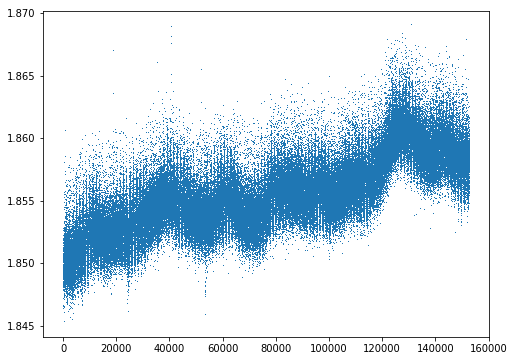

In [143]:
plot(ndata, ',')

In [144]:
t = np.arange(len(ndata))

In [145]:
m = np.sum( (t - np.mean(t))*(ndata - np.mean(ndata)) ) / np.sum( (t - np.mean(t))**2)

In [146]:
b = np.mean(ndata) - m * np.mean(t)

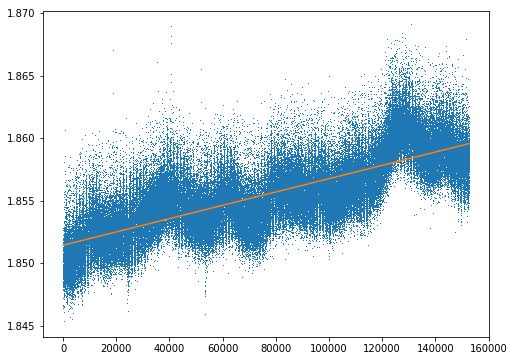

In [147]:
plot(ndata, ',')
plot(m*t +b)

In [148]:
spdata = ndata - (m*t + b)

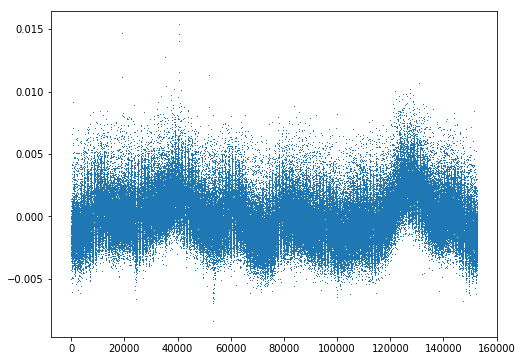

In [149]:
plot(spdata, ',')

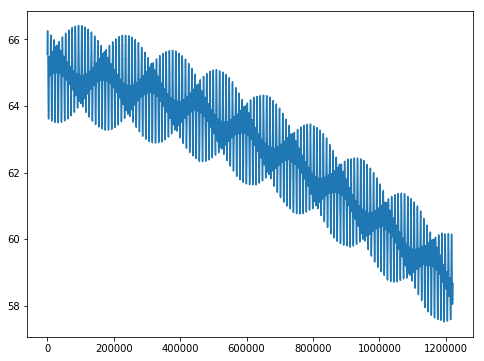

In [150]:
plot(eles)

In [52]:
flat = calibratedA[1:] - calibratedA[:-1]

In [54]:
print np.std(flat)

0.00229114811582


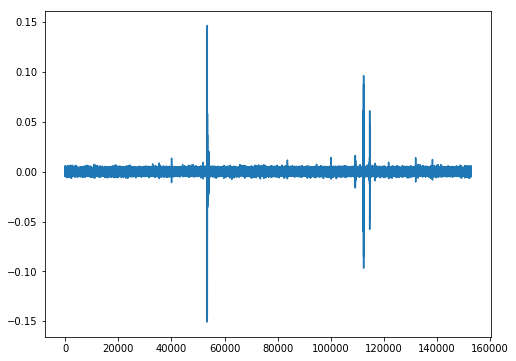

In [53]:
plot(flat)

In [59]:
mask = np.abs(flat) > 4 * np.std(flat)

In [61]:
len(mask)

152745

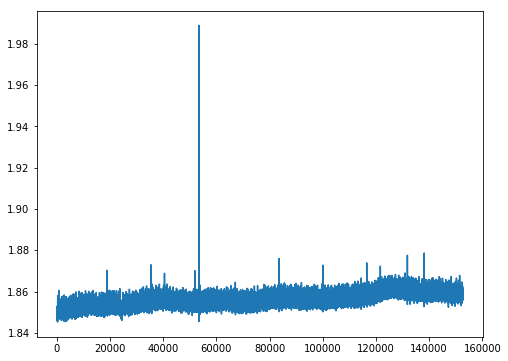

In [73]:
plot(calibratedA[1:-1][~mask[:-1]])

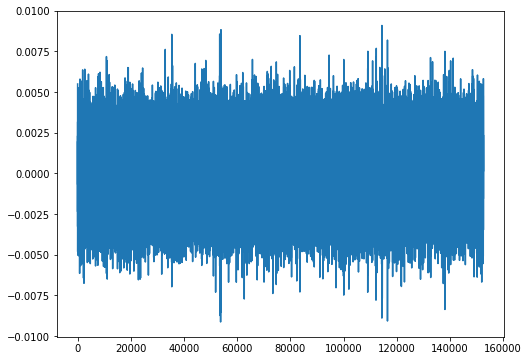

In [60]:
plot(flat[~mask])

In [48]:
len(calibratedA)

152746

In [49]:
2**16

65536

In [50]:
calibpsd = mlab.psd(calibratedA, NFFT=2**16)

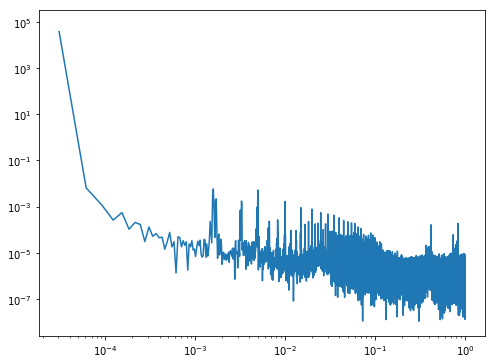

In [51]:
loglog(calibpsd[1], calibpsd[0])

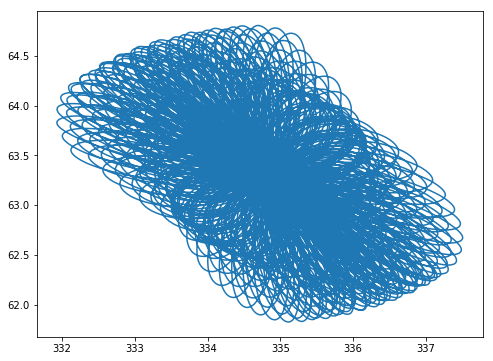

In [38]:
plot(ras, decs)

In [153]:
len(spdata)

152627

In [132]:
len(ras)

152746

In [151]:
ras = ras[4:-4][~mask]
decs = decs[4:-4][~mask]

In [152]:
len(decs)

152627

In [155]:
datamap, hits, rabins, decbins = naive_map(spdata, ras, decs, 200, 90)

In [156]:
mask = hits == 0

In [157]:
signal = datamap / hits

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':


In [158]:
signal[mask] = np.nan

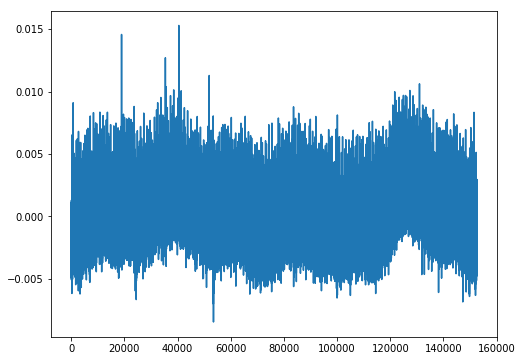

In [160]:
plot(spdata)

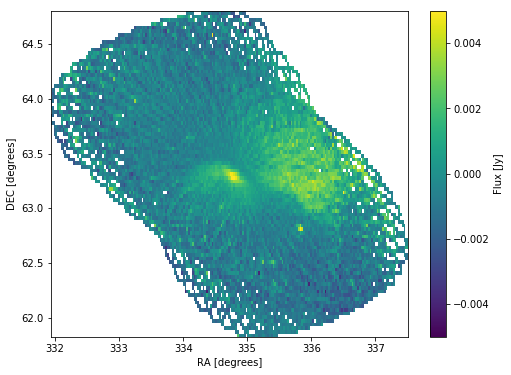

In [161]:
figsize(8,6)
pc = pcolormesh(rabins, decbins, signal.T)
clim(-0.005, 0.005)
cb = colorbar()
pc.cmap.set_under('w')
xlabel('RA [degrees]')
ylabel('DEC [degrees]')
cb.set_label('Flux [Jy]')